<a href="https://colab.research.google.com/github/Mai-CS/Enhanced-Deep-Convolutional-Forest/blob/main/enhannced_dcf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Imports***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, GlobalMaxPooling1D, Dense

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter

from tensorflow.keras.layers import Input, Dense, Dropout
from sentence_transformers import SentenceTransformer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# ***Utils***

## Dataset loading

In [2]:
def load_data(file_name):
    df = pd.read_csv(file_name, encoding="ISO-8859-1")
    df = df.dropna(subset=["ProcessedMessage"], axis=0)
    df.info()

    return df.reset_index(drop=True)

## Get maximum input length

## Balance data

In [3]:
def balance_data(X_train, y_train):
    """Oversample the dataset using SMOTE"""
    # Summarize class distribution
    counter = Counter(y_train)
    print("Before SMOTE: ", counter)

    # Oversampling
    smote_model = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote_model.fit_resample(X_train, y_train)

    # Summarize new class distribution
    counter = Counter(y_train_resampled)
    print("After SMOTE: ", counter)

    return X_train_resampled, y_train_resampled

## bge

In [4]:
!pip install transformers sentence-transformers
!pip install imbalanced-learn

In [5]:
from sentence_transformers import SentenceTransformer


model = SentenceTransformer("BAAI/bge-small-en-v1.5")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
print(model)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [7]:
!pwd

/content


## Text encoding/padding

# ***DCF***

## Building DCF

In [8]:
import numpy as np
from sklearn import metrics
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Model
import time
# Import your custom functions if they are in separate modules
# from your_module import balance_data, DCF_classify, evaluate_model, roc

# Build the DCF model
def DCF_model(
    X_train,
    X_test,
    y_train,
    y_test,
    params,
    class_weights,
):
    """Build DCF model with iterative complexity"""
    epochs = params["epochs"]

    # Start measuring execution time
    start_time = time.time()

    max_num_iterations = 10
    count = 0
    accuracy = 0  # Initialize accuracy
    best_pred = None
    best_proba = None
    best_level = 0  # Initialize best level

    for i in range(1, max_num_iterations + 1):
        print(f"\n=== Level {i} ===")
        if i == 1:
            # First level: use sentence embeddings as input
            input_dim = X_train.shape[1]
            input_layer = Input(shape=(input_dim,))
            dense_layer = Dense(128, activation='relu')(input_layer)
            dropout_layer = Dropout(0.5)(dense_layer)
            output_layer = Dense(2, activation='softmax')(dropout_layer)

            model = Model(inputs=input_layer, outputs=output_layer)

            model.compile(
                loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"],
            )
            model.fit(
                X_train, y_train, epochs=epochs, verbose=0
            )

            # Extract features for the next level
            feature_maps_model = Model(
                inputs=model.input, outputs=model.layers[-2].output
            )
            X_train_features = feature_maps_model.predict(X_train)
            X_test_features = feature_maps_model.predict(X_test)
            print("Train Output shape: " + str(X_train_features.shape))
            print("Test Output shape: " + str(X_test_features.shape))

            # Use classifiers
            probs_train, probs_test, y_pred, y_proba = DCF_classify(
                X_train_features, X_test_features, y_train, y_test, class_weights
            )

            accuracy = metrics.accuracy_score(y_test, y_pred)
            print("Accuracy of level #1 = ", accuracy)
            best_pred = y_pred
            best_proba = y_proba
            best_level = i

            print(metrics.classification_report(y_test, y_pred, digits=4))

        elif i > 1:
            # Combine previous features with classifier probabilities for the next level
            X_train_combined = np.concatenate((X_train_features, probs_train), axis=1)
            X_test_combined = np.concatenate((X_test_features, probs_test), axis=1)

            # Build new model
            input_dim = X_train_combined.shape[1]
            input_layer = Input(shape=(input_dim,))
            dense_layer = Dense(128, activation='relu')(input_layer)
            dropout_layer = Dropout(0.5)(dense_layer)
            output_layer = Dense(2, activation='softmax')(dropout_layer)

            model = Model(inputs=input_layer, outputs=output_layer)

            model.compile(
                loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"],
            )
            model.fit(
                X_train_combined, y_train, epochs=epochs, verbose=0
            )

            # Extract features for the next level
            feature_maps_model = Model(
                inputs=model.input, outputs=model.layers[-2].output
            )
            X_train_features = feature_maps_model.predict(X_train_combined)
            X_test_features = feature_maps_model.predict(X_test_combined)
            print("Train Output shape: " + str(X_train_features.shape))
            print("Test Output shape: " + str(X_test_features.shape))

            # Use classifiers
            probs_train, probs_test, y_pred, y_proba = DCF_classify(
                X_train_features, X_test_features, y_train, y_test, class_weights
            )

            new_accuracy = metrics.accuracy_score(y_test, y_pred)
            print("Accuracy of level #", i, " = ", new_accuracy)

            if accuracy < new_accuracy:
                accuracy = new_accuracy
                best_pred = y_pred
                best_proba = y_proba
                best_level = i
                count = 0
            else:
                count += 1

            print(metrics.classification_report(y_test, y_pred, digits=4))

            if count >= 3:
                print("Total number of levels = ", i)
                break

    end_time = time.time()
    print("\nRuntime of DCF = ", end_time - start_time)
    print("\nDCF's Final accuracy = ", accuracy, " at level #", best_level, "\n")

    # Evaluate model
    evaluate_model(y_test, best_pred)
    fpr, tpr, auc_value = roc(y_test, best_proba)

    return fpr, tpr, auc_value


## Classification

In [9]:
# Build DCF classifiers
def DCF_classify(X_train, X_test, y_train, y_test, class_weights):
    """Build DCF base classifiers (RandomForest and ExtraTrees)"""
    classifier1 = RandomForestClassifier(
        n_estimators=100, criterion="gini", class_weight=class_weights, random_state=0
    )
    classifier2 = RandomForestClassifier(
        n_estimators=100, criterion="entropy", class_weight=class_weights, random_state=0
    )
    classifier3 = ExtraTreesClassifier(
        n_estimators=100, criterion="gini", class_weight=class_weights, random_state=0
    )
    classifier4 = ExtraTreesClassifier(
        n_estimators=100, criterion="entropy", class_weight=class_weights, random_state=0
    )

    # Train classifiers and get probabilities
    classifier1.fit(X_train, y_train)
    probs_train1 = classifier1.predict_proba(X_train)
    probs_test1 = classifier1.predict_proba(X_test)

    classifier2.fit(X_train, y_train)
    probs_train2 = classifier2.predict_proba(X_train)
    probs_test2 = classifier2.predict_proba(X_test)

    classifier3.fit(X_train, y_train)
    probs_train3 = classifier3.predict_proba(X_train)
    probs_test3 = classifier3.predict_proba(X_test)

    classifier4.fit(X_train, y_train)
    probs_train4 = classifier4.predict_proba(X_train)
    probs_test4 = classifier4.predict_proba(X_test)

    # Concatenate probabilities
    probs_train = np.concatenate(
        (probs_train1, probs_train2, probs_train3, probs_train4), axis=1
    )
    probs_test = np.concatenate(
        (probs_test1, probs_test2, probs_test3, probs_test4), axis=1
    )

    # Calculate average probabilities and predictions
    y_pred = []
    y_proba = []
    for i in range(len(X_test)):
        avg_ham = (
            probs_test1[i][0]
            + probs_test2[i][0]
            + probs_test3[i][0]
            + probs_test4[i][0]
        ) / 4
        avg_spam = (
            probs_test1[i][1]
            + probs_test2[i][1]
            + probs_test3[i][1]
            + probs_test4[i][1]
        ) / 4
        if avg_ham > avg_spam:
            y_pred.append(0)
        else:
            y_pred.append(1)

        max_spam = max(
            probs_test1[i][1], probs_test2[i][1], probs_test3[i][1], probs_test4[i][1]
        )
        y_proba.append(max_spam)

    return probs_train, probs_test, y_pred, y_proba

## Evaluating

In [10]:
def evaluate_model(y_test, y_pred):
    """Print classification report and confusion matrix"""
    target_names = ["Ham", "Spam"]
    print(metrics.classification_report(y_test, y_pred, target_names=target_names, digits=4))
    plot_confusion_matrix(y_test, y_pred)

# Plot confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    """Visualize confusion matrix"""
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Compute ROC curve and AUC score
def roc(y_test, y_proba):
    """Compute ROC curve and AUC score"""
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
    auc = metrics.roc_auc_score(y_test, y_proba)
    return fpr, tpr, auc

# ***Deep Learning Algorithms***

## CNN

In [11]:
def cnn_model_v1(
    X_train,
    X_test,
    y_train,
    y_test,
    params,
    class_weights,
):
    epochs = params["epochs"]
    input_dim = X_train.shape[1]

    start_time = time.time()

    # Reshape embeddings to add a channel dimension
    X_train_reshaped = X_train.reshape(-1, input_dim, 1)
    X_test_reshaped = X_test.reshape(-1, input_dim, 1)

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_dim, 1)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    model.fit(X_train_reshaped, y_train, epochs=epochs, verbose=0)

    model.evaluate(X_test_reshaped, y_test)
    y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)
    y_proba = model.predict(X_test_reshaped)[::, 1]

    end_time = time.time()
    print("\nRuntime of 1-CNN = ", end_time - start_time)

    print("Classification metrics of 1-layer CNN")
    print(metrics.classification_report(y_test, y_pred, digits=4))

    fpr, tpr, auc_value = roc(y_test, y_proba)

    return fpr, tpr, auc_value

In [12]:
def cnn_model_v2(
    X_train,
    X_test,
    y_train,
    y_test,
    params,
    class_weights,
):
    epochs = params["epochs"]
    input_dim = X_train.shape[1]

    start_time = time.time()

    # Reshape embeddings to add a channel dimension
    X_train_reshaped = X_train.reshape(-1, input_dim, 1)
    X_test_reshaped = X_test.reshape(-1, input_dim, 1)

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_dim, 1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    model.fit(X_train_reshaped, y_train, epochs=epochs, verbose=0)

    model.evaluate(X_test_reshaped, y_test)
    y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)
    y_proba = model.predict(X_test_reshaped)[::, 1]

    end_time = time.time()
    print("\nRuntime of 2-CNN = ", end_time - start_time)

    print("Classification metrics of 2-layer CNN")
    print(metrics.classification_report(y_test, y_pred, digits=4))

    fpr, tpr, auc_value = roc(y_test, y_proba)

    return fpr, tpr, auc_value

In [13]:
def cnn_model_v3(
    X_train,
    X_test,
    y_train,
    y_test,
    params,
    class_weights,
):
    epochs = params["epochs"]
    input_dim = X_train.shape[1]

    start_time = time.time()

    # Reshape embeddings to add a channel dimension
    X_train_reshaped = X_train.reshape(-1, input_dim, 1)
    X_test_reshaped = X_test.reshape(-1, input_dim, 1)

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_dim, 1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    model.fit(X_train_reshaped, y_train, epochs=epochs, verbose=0)

    model.evaluate(X_test_reshaped, y_test)
    y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)
    y_proba = model.predict(X_test_reshaped)[::, 1]

    end_time = time.time()
    print("\nRuntime of 3-CNN = ", end_time - start_time)

    print("Classification metrics of 3-layer CNN")
    print(metrics.classification_report(y_test, y_pred, digits=4))

    fpr, tpr, auc_value = roc(y_test, y_proba)

    return fpr, tpr, auc_value


## LSTM

In [14]:
def lstm_model(
    X_train,
    X_test,
    y_train,
    y_test,
    params,
    class_weights,
):
    units = params["units"]
    epochs = params["epochs"]
    input_dim = X_train.shape[1]

    # Determine sequence length (e.g., split embedding into chunks)
    seq_length = 8  # For example, split into 8 parts
    feature_dim = input_dim // seq_length

    # Ensure feature_dim divides input_dim exactly
    assert input_dim % seq_length == 0, "Input dimension not divisible by sequence length."

    start_time = time.time()

    # Reshape embeddings to create sequences
    X_train_seq = X_train.reshape(-1, seq_length, feature_dim)
    X_test_seq = X_test.reshape(-1, seq_length, feature_dim)

    model = Sequential()
    model.add(LSTM(units=units, activation="relu", input_shape=(seq_length, feature_dim)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    model.fit(X_train_seq, y_train, epochs=epochs, verbose=0)

    model.evaluate(X_test_seq, y_test)
    y_pred = np.argmax(model.predict(X_test_seq), axis=1)
    y_proba = model.predict(X_test_seq)[::, 1]

    end_time = time.time()
    print("\nRuntime of LSTM = ", end_time - start_time)

    print("Classification metrics of LSTM")
    print(metrics.classification_report(y_test, y_pred, digits=4))

    fpr, tpr, auc_value = roc(y_test, y_proba)

    return fpr, tpr, auc_value

## All DL models (CNN, LSTM)

In [15]:
def DL_models(
    DCF_fpr,
    DCF_tpr,
    DCF_auc,
    X_train,
    X_test,
    y_train,
    y_test,
    params,
    class_weights,
):
    """Compare DCF with deep learning techniques"""

    result_table = pd.DataFrame(columns=["classifiers", "fpr", "tpr", "auc"])

    print("\n*******************************1-CNN*******************************\n")
    fpr, tpr, auc_value = cnn_model_v1(
        X_train,
        X_test,
        y_train,
        y_test,
        params=params,
        class_weights=class_weights,
    )
    new_row = pd.DataFrame([{"classifiers": "1-CNN", "fpr": fpr, "tpr": tpr, "auc": auc_value}])
    result_table = pd.concat([result_table, new_row], ignore_index=True)

    print("\n*******************************2-CNN*******************************\n")
    fpr, tpr, auc_value = cnn_model_v2(
        X_train,
        X_test,
        y_train,
        y_test,
        params=params,
        class_weights=class_weights,
    )
    new_row = pd.DataFrame([{"classifiers": "2-CNN", "fpr": fpr, "tpr": tpr, "auc": auc_value}])
    result_table = pd.concat([result_table, new_row], ignore_index=True)

    print("\n*******************************3-CNN*******************************\n")
    fpr, tpr, auc_value = cnn_model_v3(
        X_train,
        X_test,
        y_train,
        y_test,
        params=params,
        class_weights=class_weights,
    )
    new_row = pd.DataFrame([{"classifiers": "3-CNN", "fpr": fpr, "tpr": tpr, "auc": auc_value}])
    result_table = pd.concat([result_table, new_row], ignore_index=True)

    print("\n*******************************LSTM*******************************\n")
    fpr, tpr, auc_value = lstm_model(
        X_train,
        X_test,
        y_train,
        y_test,
        params=params,
        class_weights=class_weights,
    )
    new_row = pd.DataFrame([{"classifiers": "LSTM", "fpr": fpr, "tpr": tpr, "auc": auc_value}])
    result_table = pd.concat([result_table, new_row], ignore_index=True)

    # Adding DCF metrics to result_table
    new_row = pd.DataFrame([{"classifiers": "DCF", "fpr": DCF_fpr, "tpr": DCF_tpr, "auc": DCF_auc}])
    result_table = pd.concat([result_table, new_row], ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index("classifiers", inplace=True)

    # Plot multiple ROC-Curve
    plot_ROC_all("ROC for DL models", result_table)


# ***Machine Learning Algorithms***

## All ML models (SVM, NB, KNN, RF)

In [16]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def ML_models(
    DCF_fpr,
    DCF_tpr,
    DCF_auc,
    features_train,
    features_test,
    y_train,
    y_test,
    class_weights,
):
    """Compare DCF with machine learning algorithms"""

    classifiers = [
        SVC(random_state=0, kernel="rbf", probability=True),
        GaussianNB(),
        KNeighborsClassifier(),
        RandomForestClassifier(
            n_estimators=100, class_weight=class_weights, random_state=0
        ),
    ]

    result_table = pd.DataFrame(columns=["classifiers", "fpr", "tpr", "auc"])

    # Train the models and record the results
    i = 0
    for cls in classifiers:
        i += 1
        # Assign classifier names based on iteration
        classifier_name = "SVM"
        if i == 2:
            classifier_name = "NB"
        elif i == 3:
            classifier_name = "KNN"
        elif i == 4:
            classifier_name = "RF"

        model = cls.fit(features_train, y_train)
        y_pred = model.predict(features_test)
        y_proba = model.predict_proba(features_test)[::, 1]

        fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
        auc = metrics.roc_auc_score(y_test, y_proba)

        # Create a new DataFrame for the current result
        new_row = pd.DataFrame([{
            "classifiers": classifier_name,
            "fpr": fpr,
            "tpr": tpr,
            "auc": auc
        }])

        # Concatenate the new row to the result_table
        result_table = pd.concat([result_table, new_row], ignore_index=True)

        print("Classification report of", cls.__class__.__name__)
        print(metrics.classification_report(y_test, y_pred, digits=4))

    # Adding DCF metrics to result_table
    new_row = pd.DataFrame([{
        "classifiers": "DCF",
        "fpr": DCF_fpr,
        "tpr": DCF_tpr,
        "auc": DCF_auc
    }])
    result_table = pd.concat([result_table, new_row], ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index("classifiers", inplace=True)

    # Plot multiple ROC-Curve
    plot_ROC_all("ROC for ML models", result_table)


# ***Plot ROC for All Models***

In [17]:
def plot_ROC_all(plot_name, result_table):
    """Plot multiple ROC-Curve"""

    fig = plt.figure(figsize=(8, 6))

    for i in result_table.index:
        plt.plot(
            result_table.loc[i]["fpr"],
            result_table.loc[i]["tpr"],
            label="{}, AUC={:.3f}".format(i, result_table.loc[i]["auc"]),
        )

    plt.plot([0, 1], [0, 1], color="orange", linestyle="--")

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.legend(prop={"size": 13}, loc="lower right")

    plt.show()
    fig.savefig("/content/" + plot_name + ".pdf")

# ***Main***

In [18]:
# # Assume previous imports and functions are present

# # Updated DL models and functions as shown above

# # Load data
# df = load_data("/content/processed_spam.csv")

# data = df.drop(["Label"], axis=1)
# targets = df["Label"]

# # Split data into training and test sets
# docs = data["ProcessedMessage"].tolist()
# labels = targets.values

# docs_X_train, docs_X_test, y_train, y_test = train_test_split(
#     docs, labels, test_size=0.20, random_state=0
# )

# # Load the BAAI/bge-small-en-v1.5 model
# model = SentenceTransformer('BAAI/bge-small-en-v1.5')

# # Encode training and test data
# X_train_embeddings = model.encode(docs_X_train, convert_to_numpy=True)
# X_test_embeddings = model.encode(docs_X_test, convert_to_numpy=True)

# # Balance data using SMOTE
# X_train_embeddings_balanced, y_train_balanced = balance_data(X_train_embeddings, y_train)

# # Set parameters
# params = {"epochs": 10, "units": 128}
# # Since data is balanced, class_weights can be None
# class_weights = None

# print("\n******************************* Run DCF *******************************\n")
# DCF_fpr, DCF_tpr, DCF_auc = DCF_model(
#     X_train_embeddings_balanced,
#     X_test_embeddings,
#     y_train_balanced,
#     y_test,
#     params=params,
#     class_weights=class_weights,
# )

# print("\n************************** Run DL classifiers *************************\n")
# DL_models(
#     DCF_fpr,
#     DCF_tpr,
#     DCF_auc,
#     X_train_embeddings_balanced,
#     X_test_embeddings,
#     y_train_balanced,
#     y_test,
#     params=params,
#     class_weights=class_weights,
# )

# print("\n************************** Run ML classifiers *************************\n")
# features_train = X_train_embeddings_balanced
# features_test = X_test_embeddings

# ML_models(
#     DCF_fpr,
#     DCF_tpr,
#     DCF_auc,
#     features_train,
#     features_test,
#     y_train_balanced,
#     y_test,
#     class_weights=class_weights,
# )


# Transfer

In [19]:
def load_data(file_name):
    df = pd.read_csv(file_name, encoding="ISO-8859-1"
    )
    df = df.dropna(subset=["text"], axis=0)
    #   df = df.drop_duplicates(subset=['ProcessedMessage'])
    df.info()

    return df.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
Before SMOTE:  Counter({0: 2940, 1: 1196})
After SMOTE:  Counter({0: 2940, 1: 2940})

******************************* Run DCF *******************************


=== Level 1 ===
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Output shape: (5880, 128)
Test Output shape: (1035, 128)
Accuracy of level #1 =  0.9826086956521739
              precision    recall  f1-score   support

           0     0.9877    0.9877    0.9877       732
           1     0.9703    0.9703    0.9703       303

    accuracy                         0.9826      1035
   macro avg     0.979

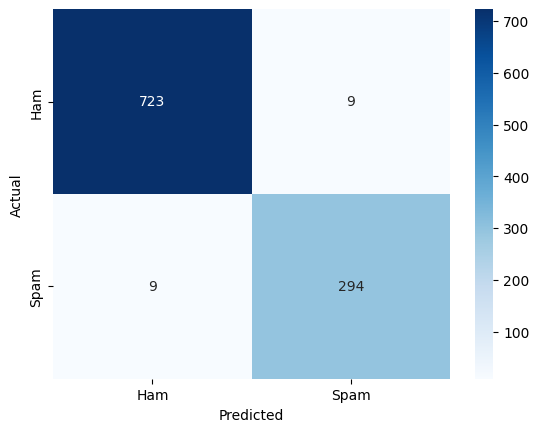


************************** Run DL classifiers *************************


*******************************1-CNN*******************************



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8012 - loss: 0.4580
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Runtime of 1-CNN =  27.74106764793396
Classification metrics of 1-layer CNN
              precision    recall  f1-score   support

           0     0.8374    0.8934    0.8645       732
           1     0.6929    0.5809    0.6320       303

    accuracy                         0.8019      1035
   macro avg     0.7652    0.7372    0.7482      1035
weighted avg     0.7951    0.8019    0.7964      1035


*******************************2-CNN*******************************



<ipython-input-15-98955f3f773e>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_table = pd.concat([result_table, new_row], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9226 - loss: 0.1814
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Runtime of 2-CNN =  92.94188332557678
Classification metrics of 2-layer CNN
              precision    recall  f1-score   support

           0     0.9391    0.9481    0.9436       732
           1     0.8716    0.8515    0.8614       303

    accuracy                         0.9198      1035
   macro avg     0.9054    0.8998    0.9025      1035
weighted avg     0.9194    0.9198    0.9195      1035


*******************************3-CNN*******************************



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9524 - loss: 0.1436
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Runtime of 3-CNN =  162.68247604370117
Classification metrics of 3-layer CNN
              precision    recall  f1-score   support

           0     0.9681    0.9549    0.9615       732
           1     0.8946    0.9241    0.9091       303

    accuracy                         0.9459      1035
   macro avg     0.9314    0.9395    0.9353      1035
weighted avg     0.9466    0.9459    0.9461      1035


*******************************LSTM*******************************



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9799 - loss: 0.0914
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Runtime of LSTM =  34.410473346710205
Classification metrics of LSTM
              precision    recall  f1-score   support

           0     0.9823    0.9850    0.9836       732
           1     0.9635    0.9571    0.9603       303

    accuracy                         0.9768      1035
   macro avg     0.9729    0.9710    0.9719      1035
weighted avg     0.9768    0.9768    0.9768      1035



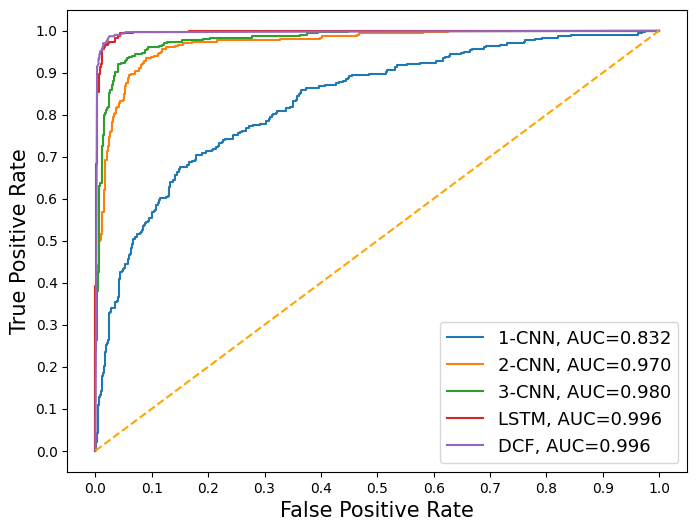


************************** Run ML classifiers *************************



<ipython-input-16-4f555436b20c>:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_table = pd.concat([result_table, new_row], ignore_index=True)


Classification report of SVC
              precision    recall  f1-score   support

           0     0.9931    0.9850    0.9890       732
           1     0.9644    0.9835    0.9739       303

    accuracy                         0.9845      1035
   macro avg     0.9788    0.9842    0.9814      1035
weighted avg     0.9847    0.9845    0.9846      1035

Classification report of GaussianNB
              precision    recall  f1-score   support

           0     0.9855    0.9317    0.9579       732
           1     0.8542    0.9670    0.9071       303

    accuracy                         0.9420      1035
   macro avg     0.9199    0.9493    0.9325      1035
weighted avg     0.9471    0.9420    0.9430      1035

Classification report of KNeighborsClassifier
              precision    recall  f1-score   support

           0     0.9986    0.9563    0.9770       732
           1     0.9042    0.9967    0.9482       303

    accuracy                         0.9681      1035
   macro avg     

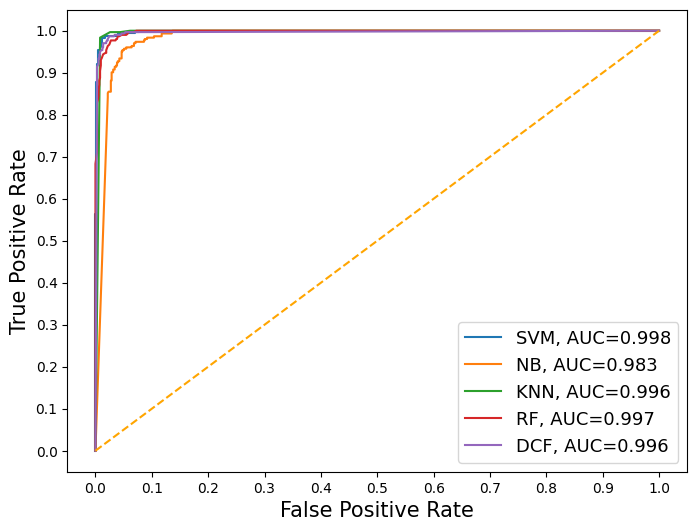

In [20]:


# Assume previous imports and functions are present

# Updated DL models and functions as shown above

# Load data
df = load_data("/content/drive/MyDrive/PROJ795data/mail_dataset.csv")

data = df.drop(["label_num"], axis=1)
targets = df["label_num"]

# Split data into training and test sets
docs = data["text"].tolist()
labels = targets.values

docs_X_train, docs_X_test, y_train, y_test = train_test_split(
    docs, labels, test_size=0.20, random_state=0
)

# Load the BAAI/bge-small-en-v1.5 model
model = SentenceTransformer('BAAI/bge-small-en-v1.5')

# Encode training and test data
X_train_embeddings = model.encode(docs_X_train, convert_to_numpy=True)
X_test_embeddings = model.encode(docs_X_test, convert_to_numpy=True)

# Balance data using SMOTE
X_train_embeddings_balanced, y_train_balanced = balance_data(X_train_embeddings, y_train)

# Set parameters
params = {"epochs": 10, "units": 128}
# Since data is balanced, class_weights can be None
class_weights = None

print("\n******************************* Run DCF *******************************\n")
DCF_fpr, DCF_tpr, DCF_auc = DCF_model(
    X_train_embeddings_balanced,
    X_test_embeddings,
    y_train_balanced,
    y_test,
    params=params,
    class_weights=class_weights,
)

print("\n************************** Run DL classifiers *************************\n")
DL_models(
    DCF_fpr,
    DCF_tpr,
    DCF_auc,
    X_train_embeddings_balanced,
    X_test_embeddings,
    y_train_balanced,
    y_test,
    params=params,
    class_weights=class_weights,
)

print("\n************************** Run ML classifiers *************************\n")
features_train = X_train_embeddings_balanced
features_test = X_test_embeddings

ML_models(
    DCF_fpr,
    DCF_tpr,
    DCF_auc,
    features_train,
    features_test,
    y_train_balanced,
    y_test,
    class_weights=class_weights,
)


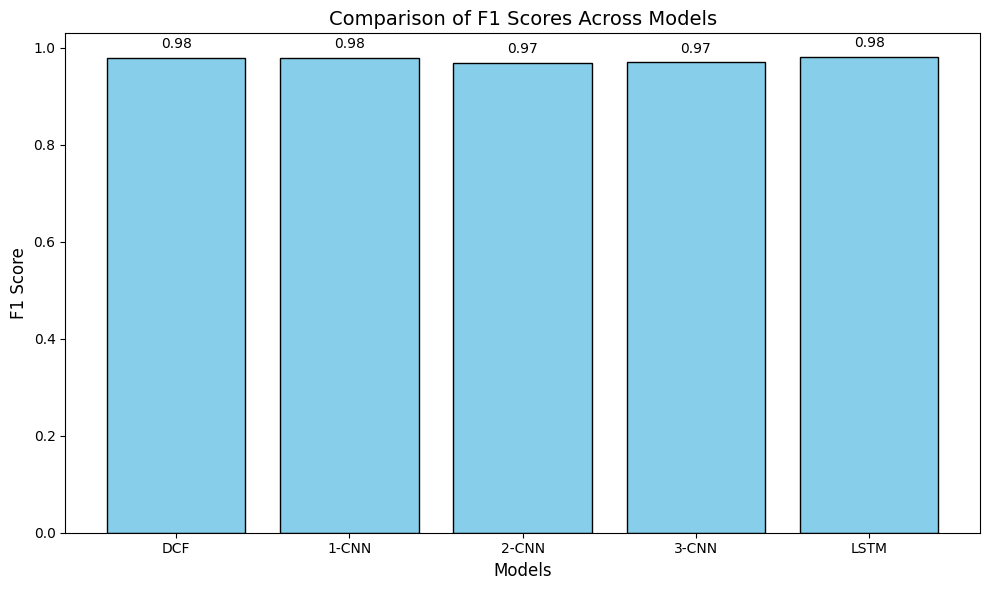

In [30]:
import matplotlib.pyplot as plt

# Data: Model names and their F1 scores
models = ['DCF', '1-CNN', '2-CNN', '3-CNN', 'LSTM']
f1_scores = [0.9798, 0.9801, 0.9692, 0.9702, 0.9818]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Comparison of F1 Scores Across Models', fontsize=14)
plt.ylim(0, 1.03)  # F1 score range is typically 0 to 1

# Annotate the F1 scores above the bars
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


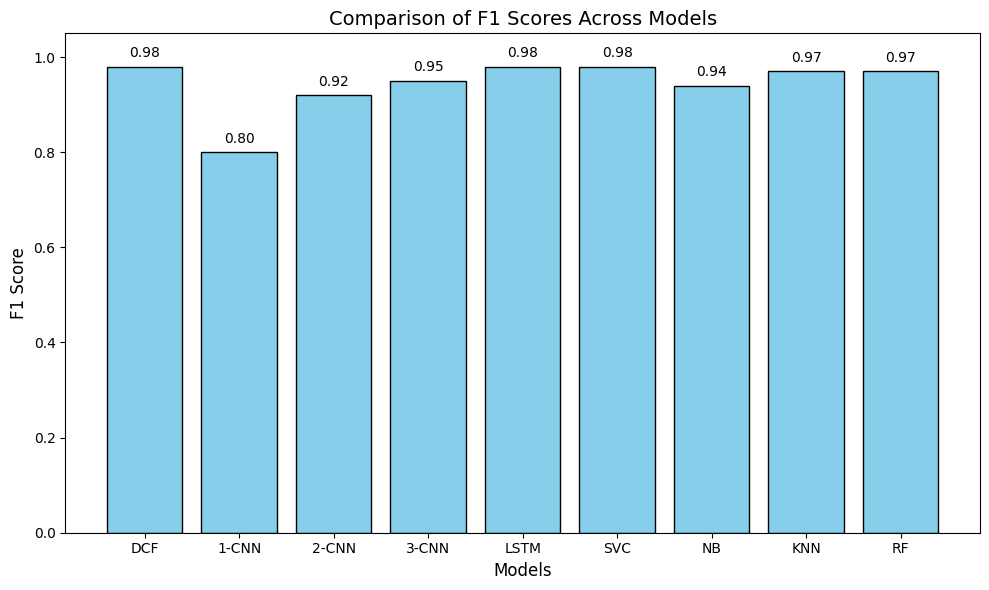

In [32]:
import matplotlib.pyplot as plt

# Data: Model names and their F1 scores
models = ['DCF', '1-CNN', '2-CNN', '3-CNN', 'LSTM', 'SVC', 'NB', 'KNN', 'RF']
f1_scores = [0.98, 0.80, 0.92, 0.95, 0.98, 0.98, 0.94, 0.97, 0.97]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Comparison of F1 Scores Across Models', fontsize=14)
plt.ylim(0, 1.05)  # Adjust ylim to create extra space above the bars

# Annotate the F1 scores above the bars with adjusted position
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


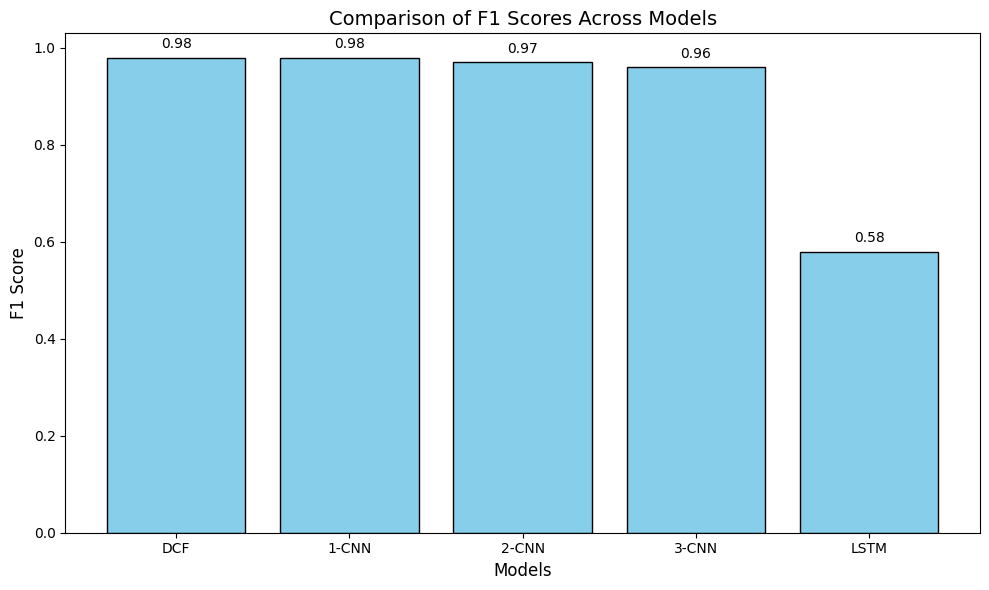

In [31]:
import matplotlib.pyplot as plt

# Data: Model names and their F1 scores
models = ['DCF', '1-CNN', '2-CNN', '3-CNN', 'LSTM']
f1_scores = [0.98, 0.98, 0.97, 0.96, 0.58]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Comparison of F1 Scores Across Models', fontsize=14)
plt.ylim(0, 1.03)  # F1 score range is typically 0 to 1

# Annotate the F1 scores above the bars
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()
